In [1]:
# basic
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

# preprocess
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# models
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
# model tensorflow
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU
from keras.optimizers import SGD, Adam

# optimizer
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime
#import sys
#import gc

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

In [3]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocess

In [4]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

In [5]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

## Drop unimportant features

In [6]:
train_test.drop(['car name', 'car_brand'], axis=1, inplace=True)
display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,23.059782,6,140,110.0,2815,17.977429,80,1
1,3,17.674521,8,350,150.0,4456,13.514535,72,1
2,4,17.136353,8,302,140.0,2774,13.209912,79,1
3,7,22.664666,6,400,85.0,2190,15.196381,71,1
4,9,17.872018,8,429,220.0,2245,9.621400,70,1
...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,225,105.0,3870,15.376311,76,1
996,993,NaN,4,140,112.0,2720,13.616843,82,1
997,996,NaN,8,318,110.0,2774,13.272636,75,1
998,998,NaN,4,90,75.0,2807,17.792560,77,1


## Standard Scaler

In [7]:
train_test_svr = train_test.copy()

cols = ['displacement', 'horsepower', 'acceleration']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
train_test_svr[cols] = scaler.fit_transform(train_test_svr[cols])
display(train_test_svr)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,23.059782,6,-0.483685,0.143900,2815,1.195071,80,1
1,3,17.674521,8,1.521800,1.333045,4456,-0.797646,72,1
2,4,17.136353,8,1.063404,1.035759,2774,-0.933663,79,1
3,7,22.664666,6,1.999297,-0.599315,2190,-0.046689,71,1
4,9,17.872018,8,2.276245,3.414047,2245,-2.535961,70,1
...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,0.328059,-0.004743,3870,0.033651,76,1
996,993,NaN,4,-0.483685,0.203358,2720,-0.751965,82,1
997,996,NaN,8,1.216202,0.143900,2774,-0.905656,75,1
998,998,NaN,4,-0.961181,-0.896601,2807,1.112525,77,1


# Encoding

In [8]:
cat_cols = ['cylinders', 'model year', 'origin']#, 'car name', 'car_brand']
train_test_svr = pd.get_dummies(
    train_test_svr,
    columns=cat_cols, 
    sparse=False
)

display(train_test_svr)

,id,mpg,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
0,0,23.059782,-0.483685,0.143900,2815,1.195071,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,3,17.674521,1.521800,1.333045,4456,-0.797646,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,4,17.136353,1.063404,1.035759,2774,-0.933663,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,7,22.664666,1.999297,-0.599315,2190,-0.046689,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,9,17.872018,2.276245,3.414047,2245,-2.535961,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,0.328059,-0.004743,3870,0.033651,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
996,993,NaN,-0.483685,0.203358,2720,-0.751965,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
997,996,NaN,1.216202,0.143900,2774,-0.905656,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
998,998,NaN,-0.961181,-0.896601,2807,1.112525,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## create train, test

In [9]:
test_x = train_test[train_test['mpg'].isnull()].drop(['id', 'mpg'], axis=1).copy()
train_x = train_test.dropna(subset=['mpg'], axis=0).copy()
train_y = train_x['mpg']
train_x.drop(['id', 'mpg'], axis=1, inplace=True)

test_x_svr = train_test_svr[train_test_svr['mpg'].isnull()].drop(['id', 'mpg'], axis=1).copy()
train_x_svr = train_test_svr.dropna(subset=['mpg'], axis=0).drop(['id', 'mpg'], axis=1).copy()

print('test_x')
display(test_x.head())

print('train_y')
display(train_y)

print('train_x')
display(train_x.head())

print('test_x_svr')
display(test_x_svr.head())

print('train_x_svr')
display(train_x_svr.head())

test_x


,cylinders,displacement,horsepower,weight,acceleration,model year,origin
500,4,98,67.0,2000,15.049795,81,1
501,4,97,90.0,2720,15.339172,79,1
502,4,90,75.0,2807,17.821599,77,1
503,4,140,110.0,2807,13.780354,82,2
504,4,121,85.0,3070,13.688921,73,2


train_y


0      23.059782
1      17.674521
2      17.136353
3      22.664666
4      17.872018
         ...    
495    22.798447
496    35.173640
497    17.825448
498    28.545147
499    36.011880
Name: mpg, Length: 500, dtype: float64

train_x


,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,6,140,110.0,2815,17.977429,80,1
1,8,350,150.0,4456,13.514535,72,1
2,8,302,140.0,2774,13.209912,79,1
3,6,400,85.0,2190,15.196381,71,1
4,8,429,220.0,2245,9.621400,70,1


test_x_svr


,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,model year_71,model year_72,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
500,-0.884782,-1.134430,2000,-0.112141,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
501,-0.894332,-0.450672,2720,0.017068,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
502,-0.961181,-0.896601,2807,1.125491,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
503,-0.483685,0.143900,2807,-0.678956,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
504,-0.665133,-0.599315,3070,-0.719781,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


train_x_svr


,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,model year_71,model year_72,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
0,-0.483685,0.143900,2815,1.195071,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1.521800,1.333045,4456,-0.797646,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1.063404,1.035759,2774,-0.933663,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1.999297,-0.599315,2190,-0.046689,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2.276245,3.414047,2245,-2.535961,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


# Define Functions

In [10]:
class Model1_LGBM:

    def __init__(self, params):
        self.params = params
        self.params['max_depth'] = int(self.params['max_depth'])
        self.params['num_leaves'] = int(self.params['num_leaves'])
        self.params['min_data_in_leaf'] = int(self.params['min_data_in_leaf'])
        self.model = lgb.LGBMRegressor(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        #self.params['max_depth'] = int(self.params['max_depth'])
        #self.params['num_leaves'] = int(self.params['num_leaves'])
        #self.params['min_data_in_leaf'] = int(self.params['min_data_in_leaf'])
        
        #model = lgb.LGBMRegressor(**self.params)
        #model = self.model
        self.model.fit(tr_x, tr_y)
        #self.model = model

    def predict(self, x):
        return self.model.predict(x)

In [11]:
class Model1_SVR:
    def __init__(self, params):
        self.params = params
        self.model = SVR(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
        #self.model = model
    
    def predict(self, x):
        return self.model.predict(x)

In [12]:
class Model1_NN:

    def __init__(self, params):
        self.params = params       

        # Layer Setting
        self.model = Sequential()
        self.model.add(Dropout(self.params['input_dropout'], input_shape=(train_x.shape[1],)))# 入力層
        for i in range(int(self.params['hidden_layers'])):# 中間層
            self.model.add(Dense(int(self.params['hidden_units'])))
            if self.params['batch_norm'] == 'before_act':
                self.model.add(BatchNormalization())
            if self.params['hidden_activation'] == 'prelu':
                self.model.add(PReLU())
            elif self.params['hidden_activation'] == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(self.params['input_dropout']))
        self.model.add(Dense(1))# 出力層

        # オプティマイザ
        if self.params['optimizer']['type'] == 'sgd':
            optimizer = SGD(lr=self.params['optimizer']['lr'], decay=1e-6, momentum=0.9, nesterov=True)
        elif self.params['optimizer']['type'] == 'adam':
            optimizer = Adam(lr=self.params['optimizer']['lr'], beta_1=0.9, beta_2=0.999, decay=0.)
        else:
            raise NotImplementedError

        # 目的関数、評価指標などの設定
        self.model.compile(loss='mean_squared_error',
                           optimizer=optimizer, metrics=['mse'])
        
    def fit(self, tr_x, tr_y, va_x, va_y):
        
        # パラメータ
        #input_dropout = self.params['input_dropout']
        #hidden_layers = int(self.params['hidden_layers'])
        #hidden_units = int(self.params['hidden_units'])
        #hidden_activation = self.params['hidden_activation']
        #hidden_dropout = self.params['hidden_dropout']
        #batch_norm = self.params['batch_norm']
        #optimizer_type = self.params['optimizer']['type']
        #optimizer_lr = self.params['optimizer']['lr']
        #batch_size = int(self.params['batch_size'])
        
        # 標準化
        self.scaler = StandardScaler()
        tr_x = self.scaler.fit_transform(tr_x)
        va_x = self.scaler.transform(va_x)        

        # エポック数、アーリーストッピング
        # あまりepochを大きくすると、小さい学習率のときに終わらないことがあるので注意
        nb_epoch = 200
        patience = 20
        early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

        # 学習の実行
        history = self.model.fit(tr_x, tr_y,
                                 epochs=nb_epoch,
                                 batch_size=int(self.params['batch_size']), verbose=0,
                                 validation_data=(va_x, va_y),
                                 callbacks=[early_stopping])

    def predict(self, x):
        # 予測
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred


In [48]:
# 線形モデル
class Model2_Ridge:

    def __init__(self):
        self.model = Ridge()
        self.scaler = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.scaler = StandardScaler()
        self.scaler.fit(tr_x)
        tr_x = self.scaler.transform(tr_x)
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        x = self.scaler.transform(x)
        pred = self.model.predict(x)
        return pred

In [14]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(x, y, args):  
    if args['model_type'] == 'lgb':
        del args['model_type']
        reg = Model1_LGBM(args)
    elif args['model_type'] == 'svr':
        del args['model_type']
        reg = Model1_SVR(args)
    elif args['model_type'] == 'nn':
        del args['model_type']
        reg = Model1_NN(args)

    scores = []
    
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    for tr_idx, va_idx in kf.split(x, y):
        tr_x = x.iloc[tr_idx]
        tr_y = y.iloc[tr_idx]
        va_x = x.iloc[va_idx]
        va_y = y.iloc[va_idx]
        
        reg.fit(tr_x, tr_y, va_x, va_y)        
        va_pred = reg.predict(va_x)
        score = RMSE(va_y, va_pred)
        scores.append(score)
        
    #kf = KFold(n_splits=4, shuffle=True, random_state=42)
    #score_func = {'score': make_scorer(RMSE)}
    #cv_result = cross_validate(estimator=reg.model, X=x, y=y, cv=kf, scoring=score_func)
    
    return {
        #'loss':cv_result['test_score'].mean(),
        'loss': np.mean(scores),
        'status':STATUS_OK,
        'params':args
    }

def objective_nn(x, y, args):
    if args['model_type'] == 'nn':
        del args['model_type']
        reg = Model1_NN(args)
    else:
        return
    
    scores = []
        
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    for tr_idx, va_idx in kf.split(x, y):
        tr_x = x.iloc[tr_idx]
        tr_y = y.iloc[tr_idx]
        va_x = x.iloc[va_idx]
        va_y = y.iloc[va_idx]
        
        model = Model1_NN(args)
        model.fit(tr_x, tr_y, va_x, va_y)        
        va_pred = model.predict(va_x)
        score = RMSE(va_y, va_pred)
        print(f'params:{args} \n RMSE:{score:.4f}')
        scores.append(score)
        
    return {
        'loss':np.mean(scores),
        'status':STATUS_OK,
        'params':args
    }

# HyperOpt

## LightGBM

In [19]:
params_lgb = {
    'model_type': 'lgb',
    'alpha' : hp.loguniform(label='alpha', low=np.log(1e-8), high=np.log(0.2)),
    'bagging_fraction': hp.quniform(label='bagging_fraction', low=0.4, high=0.80, q=0.05),
    'feature_fraction': hp.quniform(label='feature_fraction', low=0.4, high=0.7, q=0.05),
    'gamma': hp.quniform(label='gamma', low=0.1, high=0.7, q=0.1),
    'lambda' : hp.loguniform(label='lambda', low=np.log(1e-6), high=np.log(0.6)),
    'max_depth': hp.quniform(label='max_depth', low=5, high=15, q=1),
    'min_child_weight': hp.quniform(label='min_child_weight', low=1, high=5, q=1),
    'min_data_in_leaf': hp.quniform(label='min_data_in_leaf', low=8, high=14, q=2),
    'num_leaves': hp.quniform(label='num_leaves', low=10, high=60, q=10)
}

f_lgb = partial(objective, train_x, train_y)
trials_lgb = Trials()

best_lgb = fmin(
    fn=f_lgb,
    space=params_lgb,
    algo=tpe.suggest,
    trials=trials_lgb,
    max_evals=500
)

100%|██████████████████████████████████████████████| 500/500 [01:21<00:00,  6.10trial/s, best loss: 2.9092174660265107]


,loss,alpha,bagging_fraction,feature_fraction,gamma,lambda,max_depth,min_child_weight,min_data_in_leaf,num_leaves
0,2.909217,7.853317e-05,0.55,0.55,0.5,0.000125,9,5.0,10,60
1,2.909230,1.353224e-04,0.55,0.55,0.5,0.000123,9,5.0,10,50
2,2.909235,1.920864e-04,0.55,0.55,0.5,0.000142,9,5.0,10,60
3,2.909235,8.280244e-05,0.55,0.55,0.5,0.000121,9,5.0,10,50
4,2.909242,1.648115e-04,0.55,0.55,0.5,0.000155,9,5.0,10,50
5,2.909243,1.037562e-05,0.50,0.55,0.5,0.000185,9,5.0,10,40
6,2.909243,8.944580e-02,0.50,0.55,0.5,0.000159,9,5.0,10,50
7,2.909243,6.680606e-05,0.60,0.55,0.5,0.000152,9,5.0,10,50
8,2.909243,7.859898e-05,0.55,0.55,0.5,0.000146,9,5.0,10,50
9,2.909243,2.851833e-05,0.50,0.55,0.5,0.000126,9,5.0,10,60


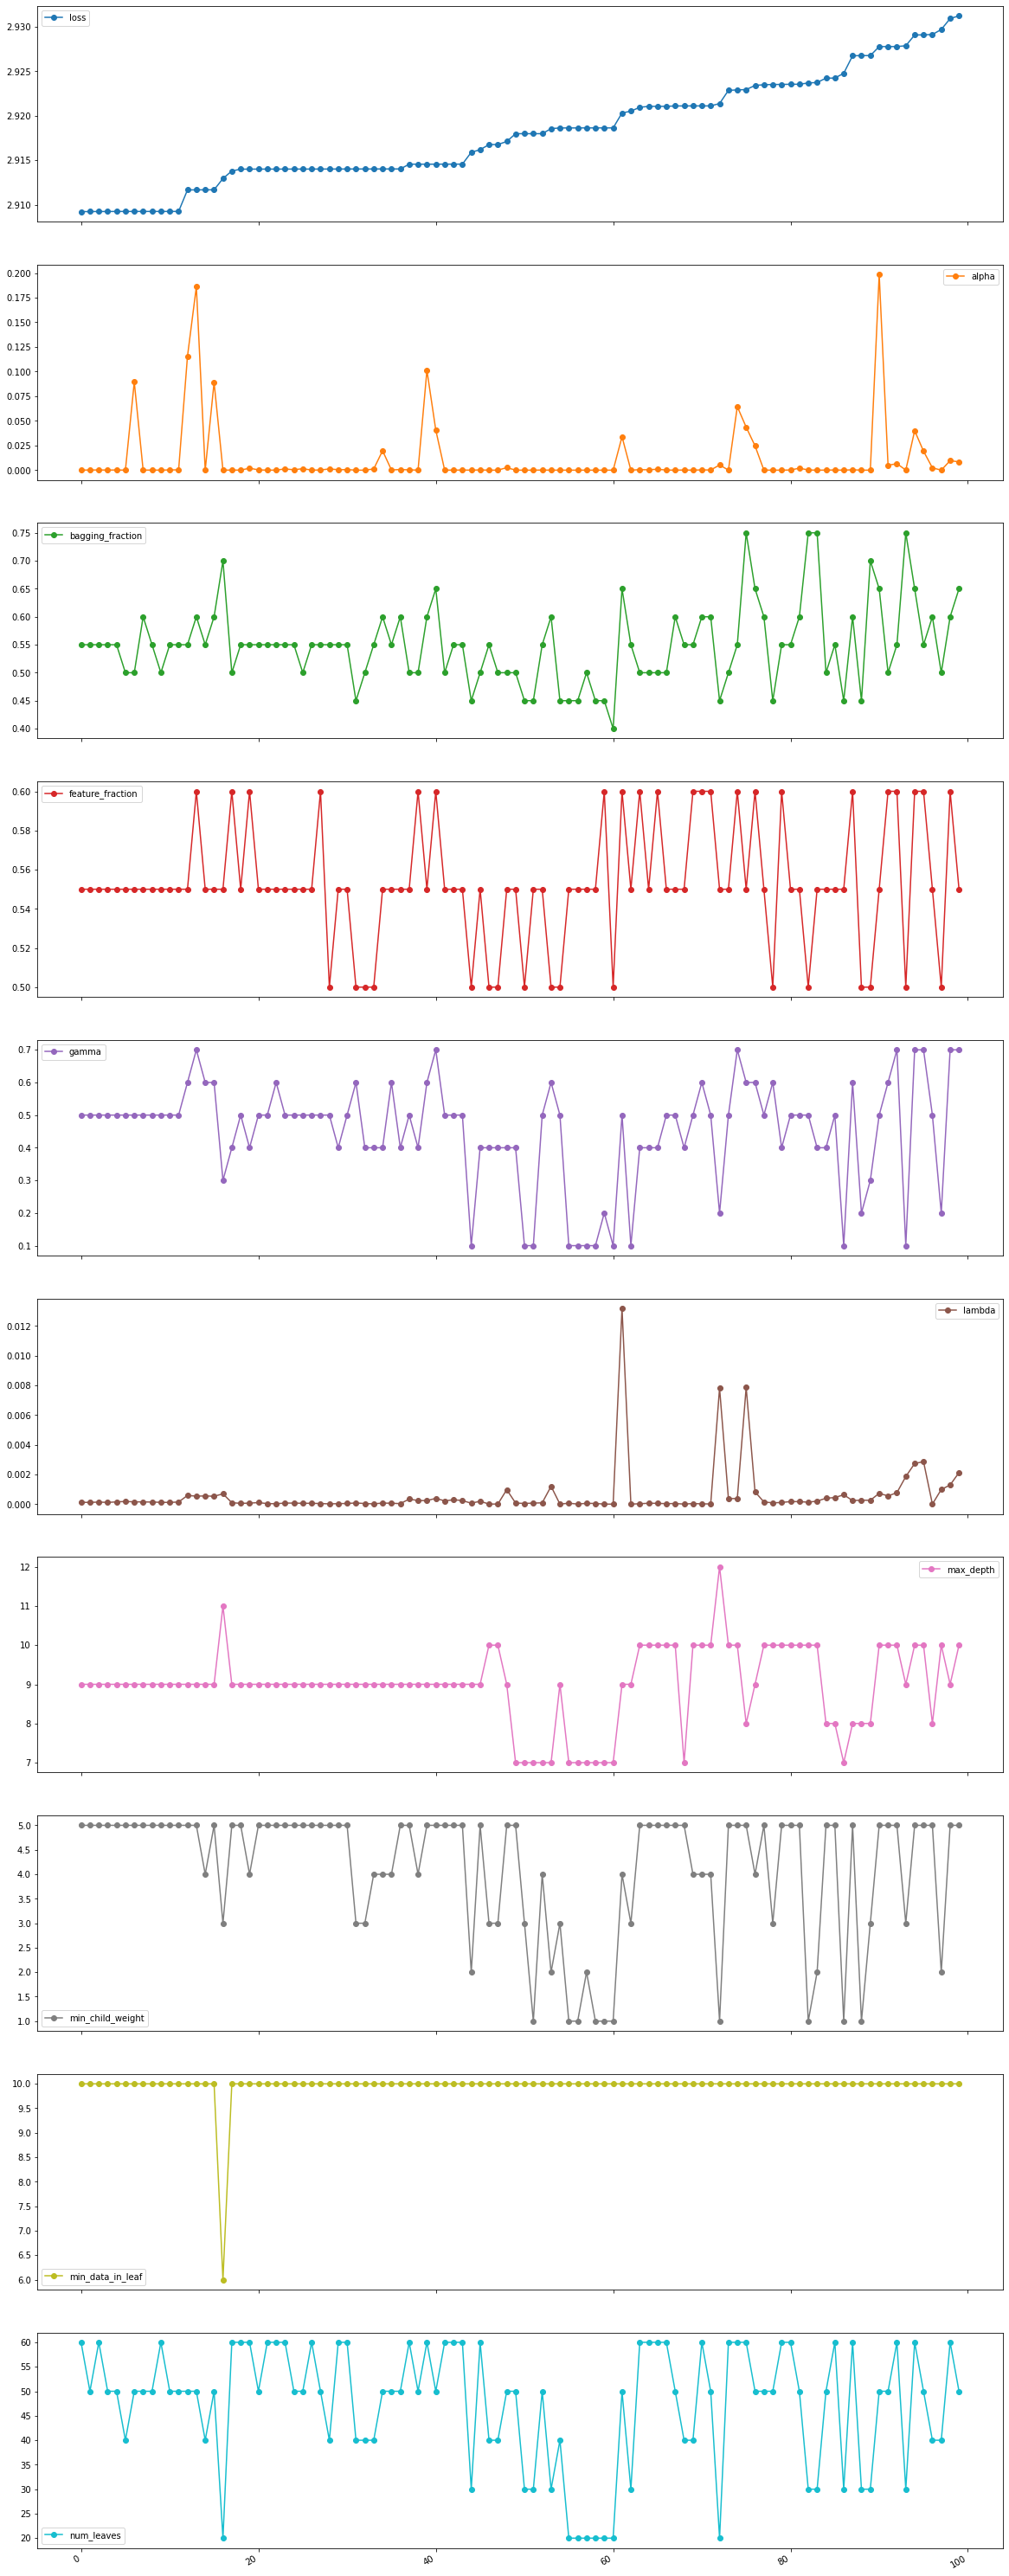

In [20]:
# trialsからスコアとパラメータを取り出し
result_lgb = [(i['loss'], i['params']) for i in sorted(trials_lgb.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_lgb = [i[0] for i in result_lgb]
opt_params_lgb = [i[1] for i in result_lgb]
# スコアとパラメータをDataFrame化
opt_params_df_lgb = pd.concat(
    [pd.Series(losses_lgb, name='loss'), 
     pd.DataFrame(opt_params_lgb)],
    axis=1)

opt_params_df_lgb.iloc[:100, :].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

## SVR

In [30]:
params_svr = {
    'model_type': 'svr',
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(25), high=np.log(60)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(0.5), high=np.log(1.5)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(0.01), high=np.log(0.3)
    )
}

f_svr = partial(objective, train_x_svr, train_y)
trials_svr = Trials()

best_svr = fmin(
    fn=f_svr,
    space=params_svr,
    algo=tpe.suggest,
    trials=trials_svr,
    max_evals=500
)

100%|███████████████████████████████████████████████| 500/500 [00:28<00:00, 17.55trial/s, best loss: 3.969049321087547]


,loss,C,epsilon,gamma,kernel
0,3.969049,58.050039,1.124520,0.032699,rbf
1,3.969206,59.456843,1.181697,0.031120,rbf
2,3.969541,55.225071,1.055593,0.034371,rbf
3,3.969714,57.762147,1.073235,0.031782,rbf
4,3.969736,56.516690,1.170332,0.032492,rbf
5,3.969802,56.155075,1.180540,0.033292,rbf
6,3.970102,53.633821,1.005006,0.036530,rbf
7,3.970221,57.710850,1.125749,0.033667,rbf
8,3.970262,55.799407,0.985443,0.033703,rbf
9,3.970292,58.491869,1.255402,0.031957,rbf


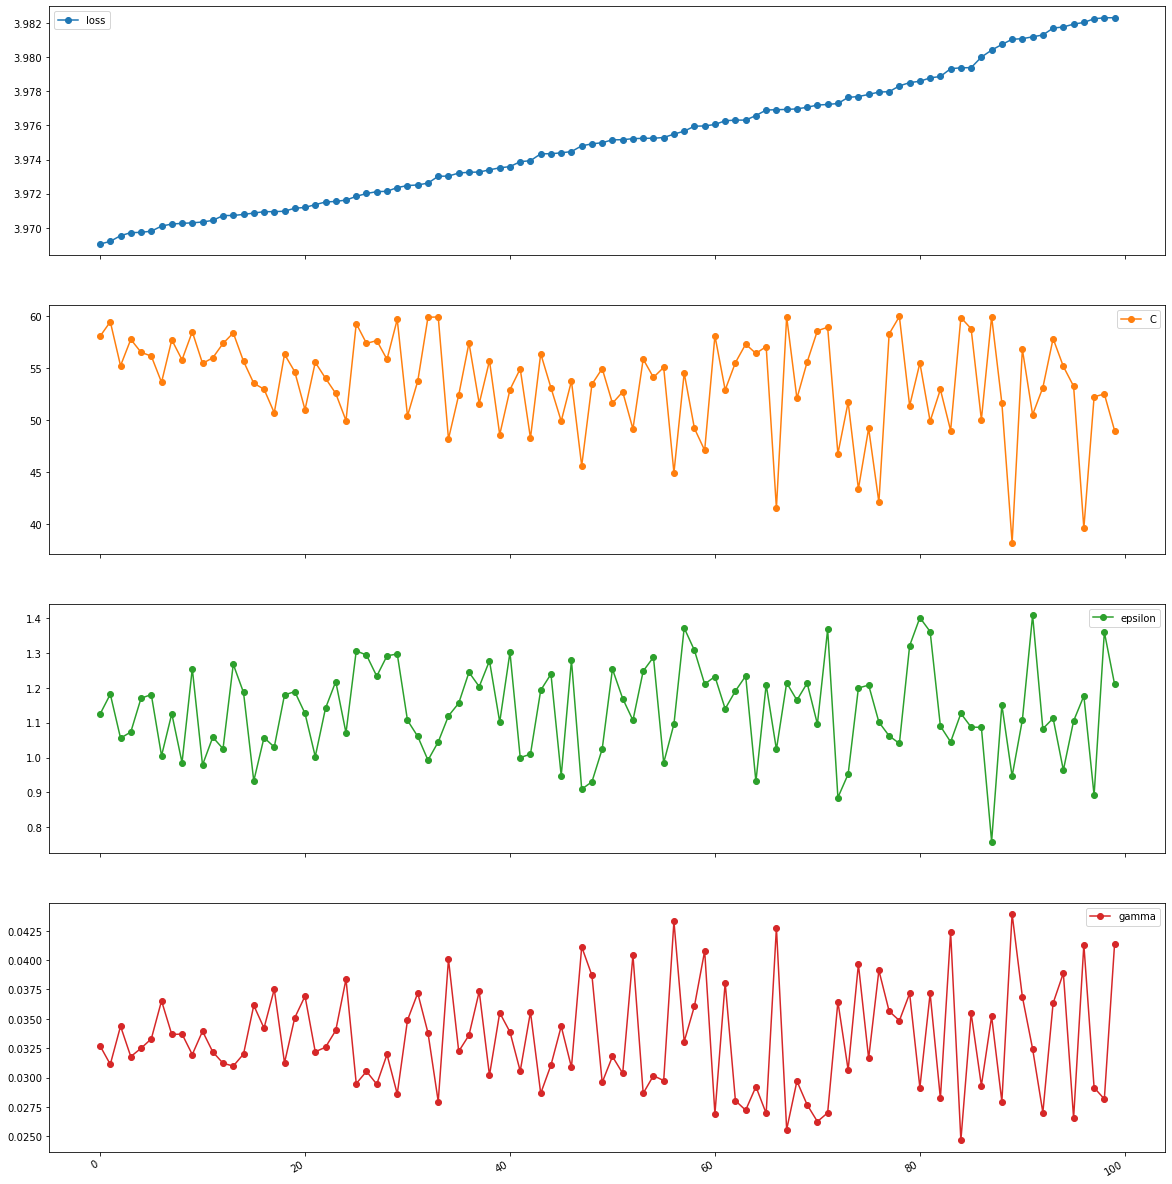

In [31]:
# trialsからスコアとパラメータを取り出し
result_svr = [(i['loss'], i['params']) for i in sorted(trials_svr.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_svr = [i[0] for i in result_svr]
opt_params_svr = [i[1] for i in result_svr]
# スコアとパラメータをDataFrame化
opt_params_df_svr = pd.concat(
    [pd.Series(losses_svr, name='loss'), 
     pd.DataFrame(opt_params_svr)],
    axis=1)

opt_params_df_svr.iloc[:100, :].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

## Neural Network

In [36]:
params_nn ={
    'model_type': 'nn',
    'batch_norm': hp.choice(
        label='batch_norm', options=['no'], 
    ),
    'batch_size': hp.quniform(label='batch_size', low=10, high=100, q=16),
    'hidden_activation': hp.choice(label='hidden_activation', options=['prelu', 'relu']),
    'hidden_dropout': hp.quniform(label='hidden_dropout', low=0.025, high=0.5, q=0.05),
    'hidden_layers': 4,#hp.quniform(label='hidden_layers', low=3, high=4, q=1),
    'hidden_units': hp.quniform(label='hidden_units', low=180, high=320, q=16),
    'input_dropout': hp.quniform(label='input_dropout', low=0.05, high=0.4, q=0.025),
    'optimizer': hp.choice(
        label='optimizer',
        options=[{'type': 'adam',
                  'lr': hp.loguniform(
                      label='adam_lr', low=np.log(0.0001), high=np.log(0.01)
                  )},
                 #{'type': 'sgd', 
                 #'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}
                ])
}

max_evals = 50
trials_nn = Trials()
f_nn = partial(objective, train_x, train_y)

best = fmin(
    fn=f_nn, 
    space=params_nn, 
    algo=tpe.suggest, 
    trials=trials_nn,
    max_evals=max_evals
)

100%|████████████████████████████████████████████████| 50/50 [10:18<00:00, 12.37s/trial, best loss: 2.7738736717953945]


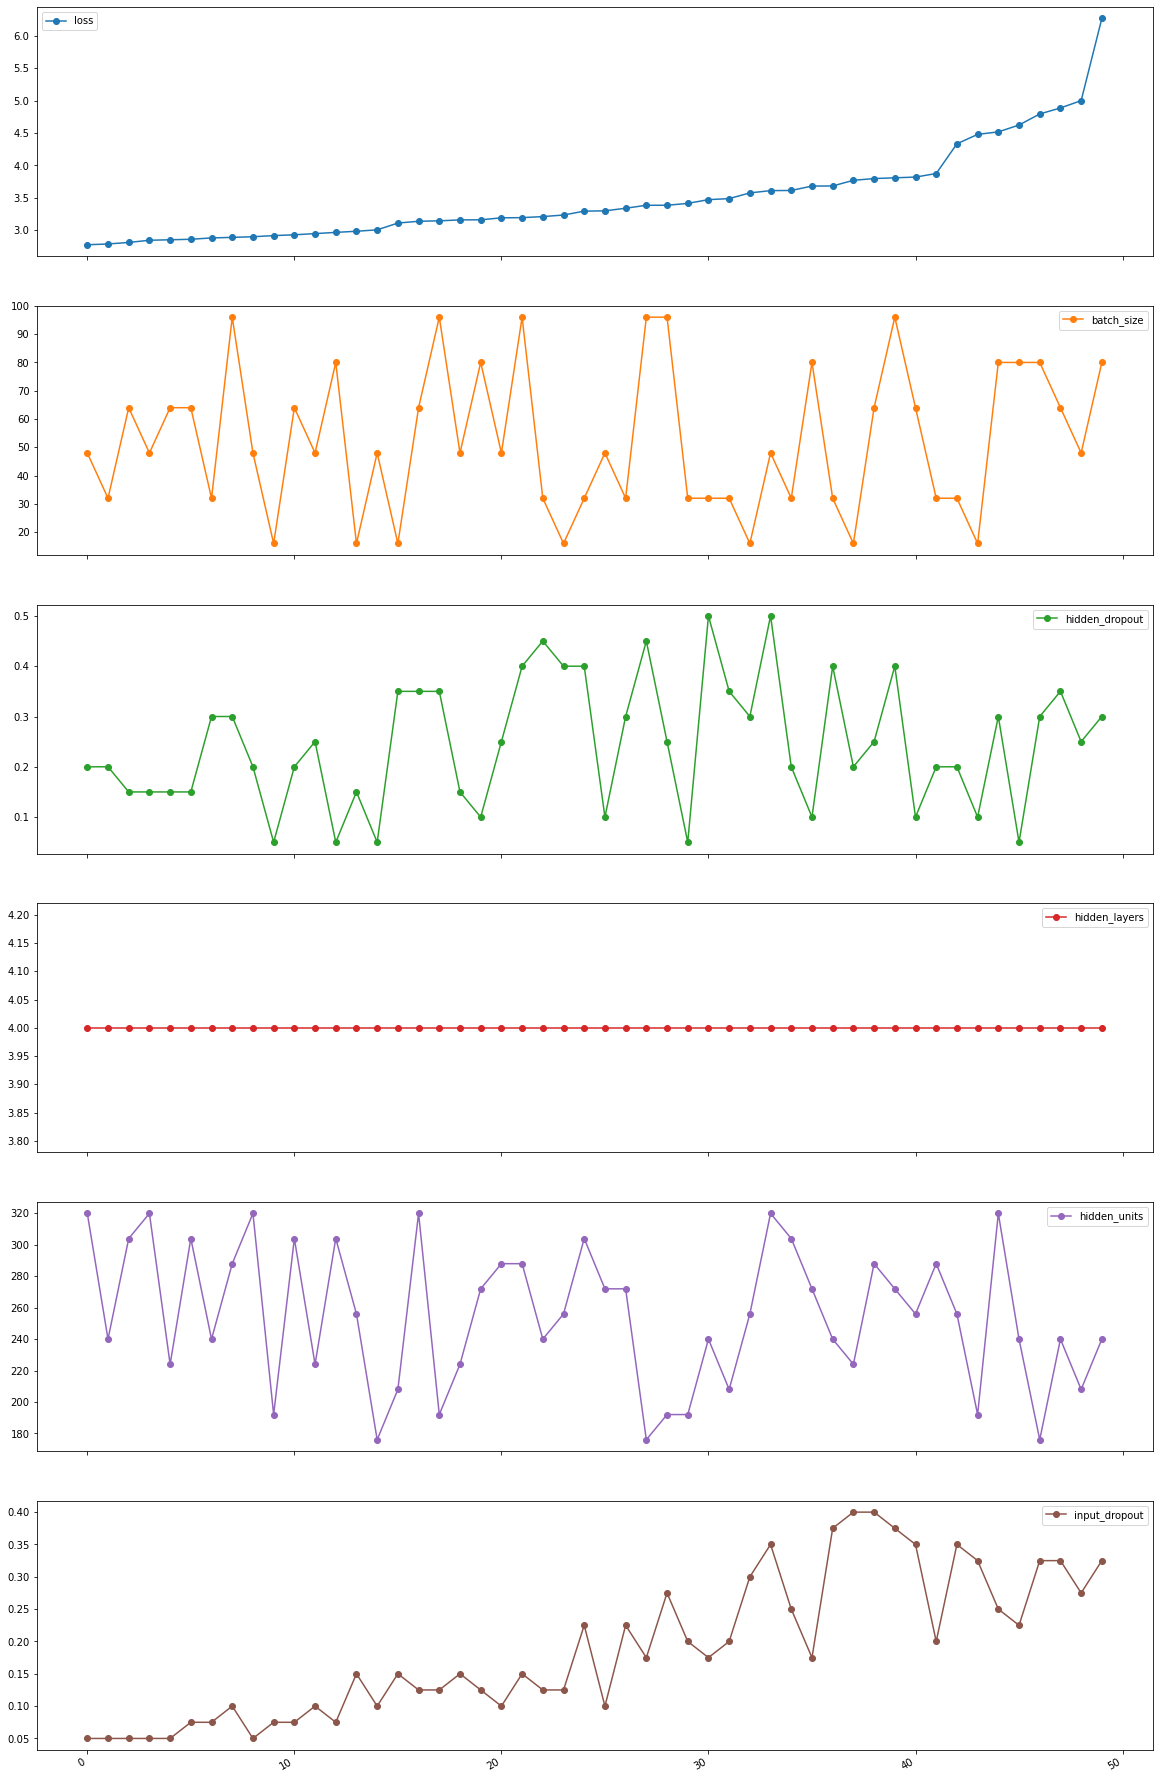

In [37]:
# trialsからスコアとパラメータを取り出し
result_nn = [(i['loss'], i['params']) for i in sorted(trials_nn.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_nn = [i[0] for i in result_nn]
opt_params_nn = [i[1] for i in result_nn]
# スコアとパラメータをDataFrame化
opt_params_df_nn = pd.concat(
    [pd.Series(losses_nn, name='loss'), 
     pd.DataFrame(opt_params_nn)],
    axis=1)

opt_params_df_nn.iloc[:100, :].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

In [38]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

# features
train_test.to_pickle('../features/feature_train-test_' + dt + '.pkl')
train_test_svr.to_pickle('../features/feature_train-test_' + dt + '_svr.pkl')

# best parameter
pickle.dump(opt_params_lgb[0], open('../logs/params_' + dt + '_lgb.pickle', 'wb'))
pickle.dump(opt_params_svr[0], open('../logs/params_' + dt + '_svr.pickle', 'wb'))
pickle.dump(opt_params_nn[0], open('../logs/params_' + dt + '_nn.pickle', 'wb'))
# best train score
pickle.dump(losses_lgb[0], open('../logs/train_score_' + dt + '_lgb.pickle', 'wb'))
pickle.dump(losses_svr[0], open('../logs/train_score_' + dt + '_svr.pickle', 'wb'))
pickle.dump(losses_nn[0], open('../logs/train_score_' + dt + '_nn.pickle', 'wb'))

# Stacking

In [39]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []
    
    kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)    
    
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        
        va_idxes.append(va_idx)
    
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]
    
    preds_test = np.mean(preds_test, axis=0)
    
    return pred_train, preds_test

In [40]:
#ntrain = train_x.shape[0]
#ntest = test.shape[0]
SEED = 0
NFOLDS = 5

In [59]:
model_lgb = Model1_LGBM(params=opt_params_lgb[0])
#model_svr = Model1_SVR(params=opt_params_svr[0])
model_nn = Model1_NN(params=opt_params_nn[0])

pred_train_1a, pred_test_1a = predict_cv(model_lgb, train_x, train_y, test_x)
#pred_train_1b, pred_test_1b = predict_cv(model_svr, train_x_svr, train_y, test_x_svr)
pred_train_1c, pred_test_1c = predict_cv(model_nn, train_x, train_y, test_x)

In [60]:
score_1a = RMSE(train_y, pred_train_1a)
#score_1b = RMSE(train_y, pred_train_1b)
score_1c = RMSE(train_y, pred_train_1c)
print(f'model_1a(lgb) score: {score_1a:.4f}')
#print(f'model_1b(svr) score: {score_1b:.4f}')
print(f'model_1x(nn) score: {score_1c:.4f}')

model_1a(lgb) score: 2.9775
model_1x(nn) score: 3.0681


In [61]:
# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_train_1a, 'pred_1c(nn)': pred_train_1c# 'pred_1b(svr)': pred_train_1b,
})
test_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_test_1a, 'pred_1c(nn)': pred_test_1c#'pred_1b(svr)': pred_test_1b, 
})
display(train_x_2.head())
display(test_x_2.head())

,pred_1a(lgb),pred_1c(nn)
0,22.574136,22.915749
1,17.189434,16.724682
2,17.882905,19.216604
3,21.997204,22.758200
4,17.308469,16.713425


,pred_1a(lgb),pred_1c(nn)
0,35.772158,35.863842
1,28.978703,28.333847
2,27.307293,28.901672
3,31.545767,28.076639
4,24.559945,25.807657


In [62]:
model_2 = Model2_Ridge()
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
score_2 = RMSE(train_y, pred_train_2)
print(f'score: {score_2:.4f}')

score: 2.9042


# Create Submission

In [63]:
submission = pd.DataFrame({'id':sample_sub.id})

submission = pd.concat(
    [submission, pd.Series(pred_test_2, name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,36.186030
1,2,28.879249
2,5,28.238095
3,6,30.157789
4,8,25.259833
...,...,...
495,992,26.607609
496,993,30.019559
497,996,17.800216
498,998,28.277085


In [64]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

train_x_2.to_pickle('../features/feature_train_' + dt + '_stack_2.pickle')
test_x_2.to_pickle('../features/feature_test_' + dt + '_stack_2.pickle')

submission.to_csv('../data/output/sub_' + dt + '_stack_lgb-svr-nn_lr.csv', header=False, index=False)

pickle.dump(model_lgb, open('../models/model_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(model_svr, open('../models/model_' + dt + '_stack_1b_svr.pickle', 'wb'))
pickle.dump(model_nn, open('../models/model_' + dt + '_stack_1c_nn.pickle', 'wb'))
pickle.dump(model_2, open('../models/model_' + dt + '_stack_2_ridge.pickle', 'wb'))

pickle.dump(model_lgb.params, open('../logs/params_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(model_svr.params, open('../logs/params_' + dt + '_stack_1b_svr.pickle', 'wb'))
pickle.dump(model_nn.params, open('../logs/params_' + dt + '_stack_1c_nn.pickle', 'wb'))

pickle.dump(score_1a, open('../logs/train_score_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(score_1b, open('../logs/train_score_' + dt + '_stack_1b_svr.pickle', 'wb'))
pickle.dump(score_1c, open('../logs/train_score_' + dt + '_stack_1c_nn.pickle', 'wb'))
pickle.dump(score_2, open('../logs/train_score_' + dt + '_stack_2_ridge.pickle', 'wb'))